In [8]:
%load_ext memory_profiler

## 朴素PageRank

In [10]:
%%memit
import pandas as pd
import time
import matplotlib.pyplot as plt

# 1. 读取数据
df = pd.read_csv('/home/csu/pagerank/web_links.csv')

# 2. 构建图结构
edges = list(zip(df['FromNodeId'], df['ToNodeId']))
nodes = sorted(set(df['FromNodeId']).union(set(df['ToNodeId'])))
N = len(nodes)

node_to_index = {node: idx for idx, node in enumerate(nodes)}
index_to_node = {idx: node for node, idx in node_to_index.items()}

# 3. 初始化图的出边信息
out_links = {i: [] for i in range(N)}
out_degree = [0] * N

for from_id, to_id in edges:
    u = node_to_index[from_id]
    v = node_to_index[to_id]
    out_links[u].append(v)
    out_degree[u] += 1

peak memory: 1174.61 MiB, increment: 231.57 MiB


In [12]:
%%memit
# 4. 初始化 PageRank 向量
damping = 0.85
pr = [1.0 / N] * N
max_iterations = 100
epsilon = 1e-6
diff_list = []

# ✅ 开始计时
start_time = time.time()

# 5. PageRank 主循环（带收敛判断）
for iteration in range(max_iterations):
    new_pr = [0.0] * N
    dangling_sum = sum(pr[u] for u in range(N) if out_degree[u] == 0)

    for u in range(N):
        if out_degree[u] == 0:
            continue
        share = pr[u] / out_degree[u]
        for v in out_links[u]:
            new_pr[v] += damping * share

    for i in range(N):
        new_pr[i] += (1 - damping) / N
        new_pr[i] += damping * dangling_sum / N

    diff = sum(abs(new_pr[i] - pr[i]) for i in range(N))
    diff_list.append(diff)
    print(f"Iteration {iteration+1}, diff = {diff:.8f}")

    if diff < epsilon:
        print("Converged.")
        break

    pr = new_pr

# ✅ 结束计时
end_time = time.time()
total_time = end_time - start_time
print(f"Total runtime: {total_time:.2f} seconds")

Iteration 1, diff = 0.95790725
Iteration 2, diff = 0.49267780
Iteration 3, diff = 0.24389767
Iteration 4, diff = 0.12526351
Iteration 5, diff = 0.07264675
Iteration 6, diff = 0.04692311
Iteration 7, diff = 0.03269156
Iteration 8, diff = 0.02354667
Iteration 9, diff = 0.01751872
Iteration 10, diff = 0.01351175
Iteration 11, diff = 0.01057326
Iteration 12, diff = 0.00837425
Iteration 13, diff = 0.00669964
Iteration 14, diff = 0.00541124
Iteration 15, diff = 0.00438895
Iteration 16, diff = 0.00358076
Iteration 17, diff = 0.00292967
Iteration 18, diff = 0.00240797
Iteration 19, diff = 0.00198262
Iteration 20, diff = 0.00163803
Iteration 21, diff = 0.00135501
Iteration 22, diff = 0.00112359
Iteration 23, diff = 0.00093241
Iteration 24, diff = 0.00077545
Iteration 25, diff = 0.00064502
Iteration 26, diff = 0.00053785
Iteration 27, diff = 0.00044859
Iteration 28, diff = 0.00037478
Iteration 29, diff = 0.00031309
Iteration 30, diff = 0.00026194
Iteration 31, diff = 0.00021909
Iteration 32, dif

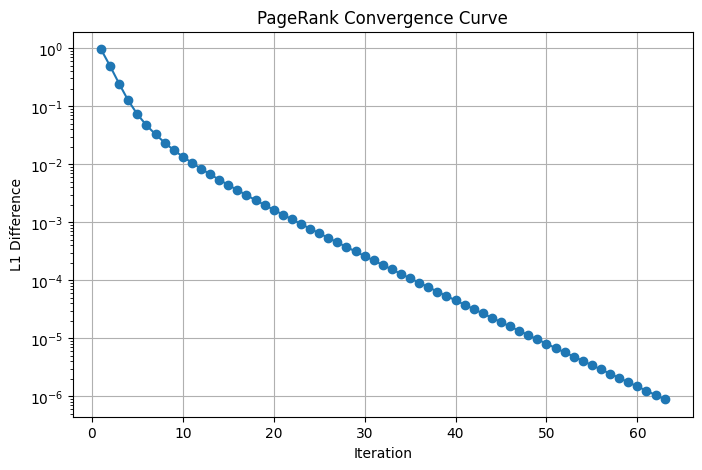

peak memory: 954.79 MiB, increment: 3.39 MiB


In [14]:
%%memit
# 6. 排序并输出前1000
result = [(index_to_node[i], pr[i]) for i in range(N)]
result.sort(key=lambda x: x[1], reverse=True)
top1000 = result[:1000]

# 7. 保存为 test_prediction.csv
df_out = pd.DataFrame(top1000, columns=["NodeId", "PageRank_Value"])
df_out.to_csv("simple_method.csv", index=False)

# ✅ 8. 收敛曲线绘图
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(diff_list)+1), diff_list, marker='o')
plt.yscale('log')
plt.title("PageRank Convergence Curve")
plt.xlabel("Iteration")
plt.ylabel("L1 Difference")
plt.grid(True)
plt.show()

## 优化版PageRank

Converged at iter 63 with diff 8.90e-07
Time elapsed: 0.52 seconds


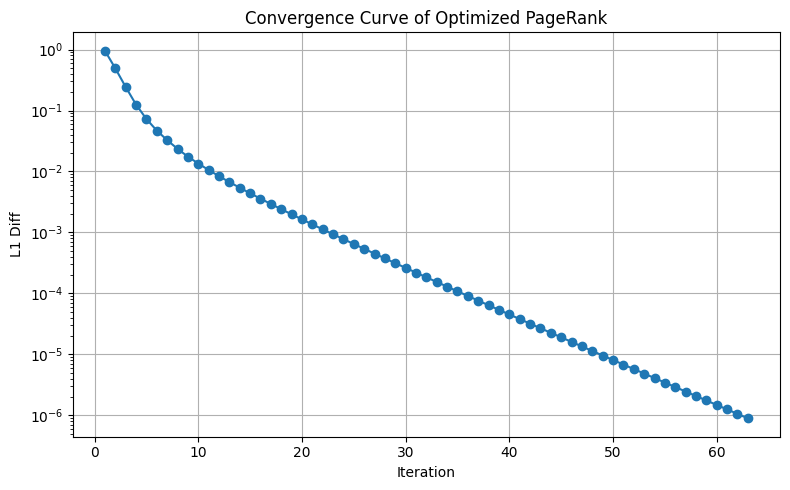

peak memory: 968.09 MiB, increment: 22.95 MiB


In [15]:
%%memit
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import time
import matplotlib.pyplot as plt

# 参数
alpha = 0.85
epsilon = 1e-6
max_iter = 100

# 读取数据
df = pd.read_csv('/home/csu/pagerank/web_links.csv')
from_ids = df['FromNodeId'].values
to_ids = df['ToNodeId'].values

# 获取节点集合
nodes = np.union1d(from_ids, to_ids)
node2idx = {node: idx for idx, node in enumerate(nodes)}
idx2node = {idx: node for node, idx in node2idx.items()}
N = len(nodes)

# 构建稀疏转移矩阵
row = [node2idx[f] for f in from_ids]
col = [node2idx[t] for t in to_ids]
data = np.ones(len(row), dtype=np.float32)

# 出度
out_degree = np.zeros(N)
for r in row:
    out_degree[r] += 1

# 构建转移概率矩阵 M (转置的，便于列操作)
data_prob = [1.0 / out_degree[r] if out_degree[r] > 0 else 0.0 for r in row]
M = csr_matrix((data_prob, (col, row)), shape=(N, N))  # 注意转置

# 初始化 PR 向量
pr = np.ones(N) / N
dangling_nodes = np.where(out_degree == 0)[0]

# 开始迭代
start_time = time.time()
diffs = []
for i in range(max_iter):
    old_pr = pr.copy()
    dangling_sum = old_pr[dangling_nodes].sum()
    
    pr = alpha * (M @ old_pr)                     # 稀疏矩阵乘法
    pr += alpha * dangling_sum / N                # 悬挂节点补偿
    pr += (1 - alpha) / N                         # 随机跳转

    diff = np.linalg.norm(pr - old_pr, 1)
    diffs.append(diff)
    if diff < epsilon:
        print(f"Converged at iter {i+1} with diff {diff:.2e}")
        break

total_time = time.time() - start_time
print(f"Time elapsed: {total_time:.2f} seconds")

# 排序输出 Top1000
topk = np.argsort(-pr)[:1000]
top_node_ids = [idx2node[idx] for idx in topk]
top_pr_values = pr[topk]
output_df = pd.DataFrame({
    'NodeId': top_node_ids,
    'PageRank_Value': top_pr_values
})
output_df.to_csv('test_prediction.csv', index=False)

# 收敛曲线图
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(diffs)+1), diffs, marker='o')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('L1 Diff')
plt.title('Convergence Curve of Optimized PageRank')
plt.grid(True)
plt.tight_layout()
plt.savefig('pagerank_optimized_convergence.png')
plt.show()
